# Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import learning_curve

from catboost import CatBoostClassifier
import xgboost as xgb

import optuna

# Processing

In [2]:
df = pd.read_csv("C:/Users/33782/Desktop/Mémoire F1/df_final_2.csv")

In [3]:
# Supposons que vous avez déjà importé votre DataFrame df_final

# Sélectionnez les colonnes à encoder
columns_to_encode = ["nationality"]

# Créez une instance de OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Adapter et transformer les colonnes sélectionnées
encoded_data = encoder.fit_transform(df[columns_to_encode])

# Créez un DataFrame avec les données encodées
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

# Supprimez les colonnes encodées du DataFrame d'origine
df.drop(columns=columns_to_encode, inplace=True)

# Concaténez le DataFrame original avec le DataFrame encodé
df_final = pd.concat([df, encoded_df], axis=1)

In [4]:
df_final["positionOrder"] = df_final["positionOrder"].apply(lambda x: 0 if x > 1 else x)

In [5]:
df_final.drop(columns=["Top 3 Finish","Yearofbirth"], inplace=True)

In [6]:
# Create a list of columns excluding the one to move
cols = [col for col in df_final.columns if col != 'positionOrder']

# Append the column to the end of the DataFrame
df_final = df_final[cols + ['positionOrder']]

In [7]:
train_df = df_final[(df_final["year"] >= 2012) & (df_final["year"] <= 2022)]
test_df = df_final[(df_final["year"] == 2024)]


X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['positionOrder'].values


X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['positionOrder'].values

In [8]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [24]:
# Normaliser les caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

In [11]:
import joblib
joblib.dump(scaler, 'scaler_svm.joblib')

['scaler_svm.joblib']

# Models

In [10]:
AdaBoost = AdaBoostClassifier(n_estimators=255,
                              learning_rate=0.1451894699645704,
                              algorithm='SAMME.R',
                              random_state=42)

CatBoost = CatBoostClassifier(iterations=294,
                              learning_rate=0.0101370551725073,
                              depth=4,
                              l2_leaf_reg=1.329169212082312,
                              verbose=0,
                              random_state=42)

GB = GradientBoostingClassifier(learning_rate=0.07091174648758228,
                                n_estimators=142,
                                max_depth=3,
                                min_samples_split=4,
                                min_samples_leaf=6,
                                random_state=42)

XGBoost = xgb.XGBClassifier(learning_rate= 0.11569159614290633,
                            n_estimators= 102,
                            max_depth= 8,
                            subsample= 1,
                            colsample_bytree= 1,
                            gamma= 0)

DecisionTree = DecisionTreeClassifier(max_depth=24,
                                      min_samples_split=2,
                                      min_samples_leaf=8,
                                      max_features='sqrt',
                                      random_state=42)

RandomForest = RandomForestClassifier(n_estimators= 105,
                                      max_depth= 91,
                                      min_samples_split=13,
                                      min_samples_leaf= 4,
                                      max_features= 'sqrt')

SupportVectorMachine = SVC(C=0.31326753946065944,
                           kernel='rbf',
                           gamma='scale',
                           random_state=42)

In [11]:
dict_of_models = {"AdaBoost" : AdaBoost,
                  "CatBoost" : CatBoost,
                  "GradientBoosting" : GB,
                  "XGBoost" : XGBoost,
                  "DecisionTree" : DecisionTree,
                  "RandomForest" : RandomForest,
                  "SVM" : SupportVectorMachine}

# Evaluation procedure

In [11]:
comparison_dict ={'model':[],
                  'score': []}

In [12]:
def evaluation(model):
    
    model.fit(X_train_scaled,y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    score = round(f1_score(y_test, y_pred),2)
    
    comparison_dict['score'].append(score)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [14]:
def learningcurve(title, model):
    
    
    train_sizes, train_scores, valid_scores = learning_curve(model,
                                                             X_train_scaled,
                                                             y_train_resampled,
                                                             train_sizes=[i/10 for i in range(1,11)])

    plt.figure(figsize=(9,3))
    plt.plot(train_sizes, train_scores.mean(axis=1), label='training',marker='.', color='blue')
    plt.plot(train_sizes, valid_scores.mean(axis=1), label='validaiton',marker='.', color='orange')
    plt.title(f"Learning curve of the {title} model")
    plt.legend(loc='lower left')
    plt.ylim(0,1)
    plt.savefig(f'C:/Users/33782/Desktop/Mémoire F1/Learning curve winner/{title}.png')

# Evaluation

In [14]:
for key, value in dict_of_models.items():
    print('------------------------------------------------------')
    print("\033[1m" + key + "\033[0m")
    print('------------------------------------------------------')
    evaluation(value)
    comparison_dict['model'].append(key)

------------------------------------------------------
AdaBoost
------------------------------------------------------
[[402  16]
 [  3  19]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       418
           1       0.54      0.86      0.67        22

    accuracy                           0.96       440
   macro avg       0.77      0.91      0.82       440
weighted avg       0.97      0.96      0.96       440

------------------------------------------------------
CatBoost
------------------------------------------------------
[[398  20]
 [  2  20]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       418
           1       0.50      0.91      0.65        22

    accuracy                           0.95       440
   macro avg       0.75      0.93      0.81       440
weighted avg       0.97      0.95      0.96       440

------------------------------------------------------
Gradien

In [15]:
comparison_dict

{'model': ['AdaBoost',
  'CatBoost',
  'GradientBoosting',
  'XGBoost',
  'DecisionTree',
  'RandomForest',
  'SVM'],
 'score': [0.67, 0.65, 0.71, 0.65, 0.56, 0.68, 0.72]}

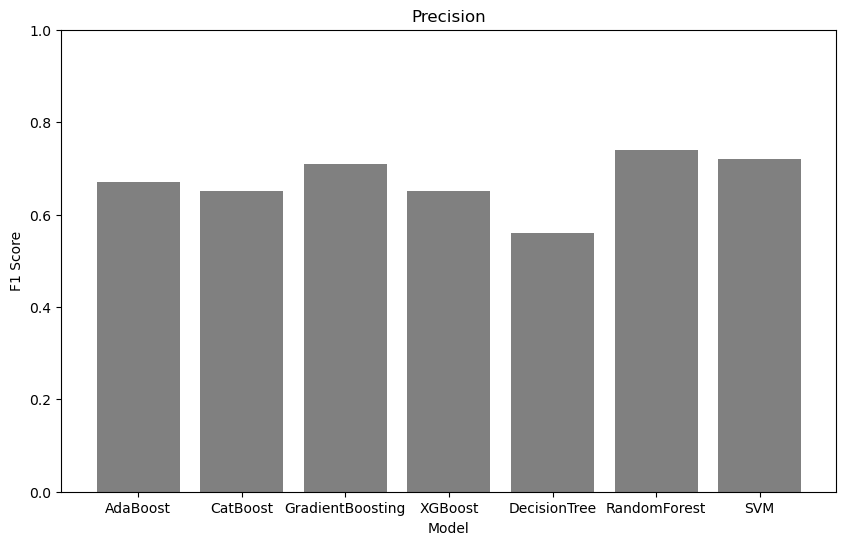

In [17]:
import matplotlib.pyplot as plt

# Données à partir du dictionnaire
models = comparison_dict['model']
scores = comparison_dict['score']

# Création du diagramme en barres avec des nuances de gris
plt.figure(figsize=(10, 6))
bars = plt.bar(models, scores, color='gray')

plt.ylim(0, 1)
# Ajout de titres et de libellés
plt.title('Precision')
plt.xlabel('Model')
plt.ylabel('F1 Score')

# Affichage du diagramme
plt.show()


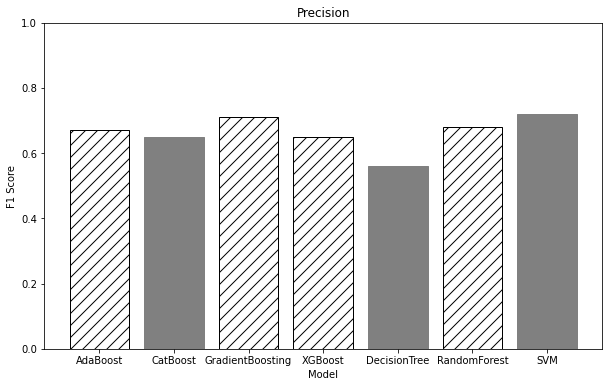

In [22]:
import matplotlib.pyplot as plt

# Données à partir du dictionnaire
models = comparison_dict['model']
scores = comparison_dict['score']

# Création du diagramme en barres avec des nuances de gris
plt.figure(figsize=(10, 6))

# Définir un motif de remplissage commun pour tous les modèles spécifiés
pattern = '///'  

bars = plt.bar(models, scores, color='white', edgecolor='black')

# Ajouter le motif de remplissage uniquement aux modèles spécifiés
specified_models = ['AdaBoost', 'GradientBoosting', 'XGBoost', 'RandomForest']
for bar, model in zip(bars, models):
    if model in specified_models:
        bar.set_hatch(pattern)
    elif model in ['CatBoost', 'DecisionTree', 'SVM']:
        bar.set_color('grey')

plt.ylim(0, 1)
# Ajout de titres et de libellés
plt.title('Precision')
plt.xlabel('Model')
plt.ylabel('F1 Score')

# Affichage du diagramme
plt.show()


# Learning Curve

In [18]:
## Code that plot learning curve
## No need to relaunch. Run the next following code to load the learning curve

##for key, value in dict_of_models.items():
##    print('------------------------------------------------------')
##    print("\033[1m" + key + "\033[0m")
##    print('------------------------------------------------------')
##    learningcurve(key,value)

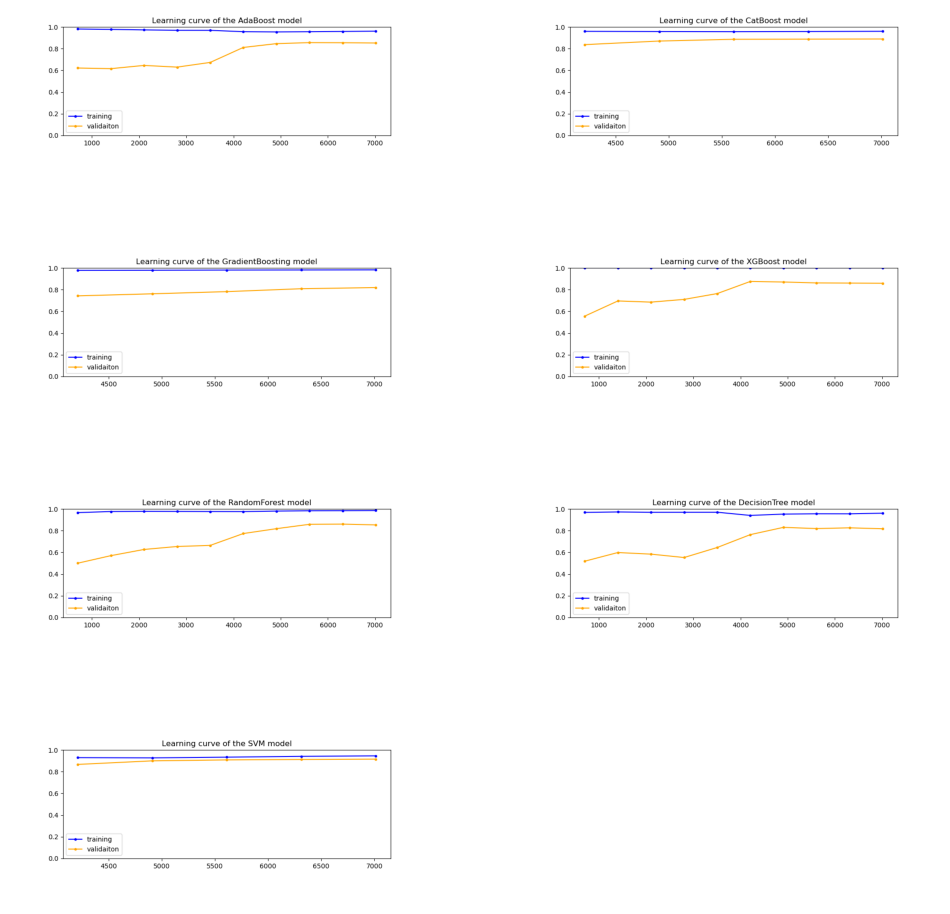

In [19]:
from IPython.display import Image, display
from PIL import Image as PILImage
import matplotlib.pyplot as plt

image1 = PILImage.open('C:/Users/33782/Desktop/Mémoire F1/Learning curve winner/AdaBoost.png')
image2 = PILImage.open('C:/Users/33782/Desktop/Mémoire F1/Learning curve winner/CatBoost.png')
image3 = PILImage.open('C:/Users/33782/Desktop/Mémoire F1/Learning curve winner/GradientBoosting.png')
image4 = PILImage.open('C:/Users/33782/Desktop/Mémoire F1/Learning curve winner/XGBoost.png')
image5 = PILImage.open('C:/Users/33782/Desktop/Mémoire F1/Learning curve winner/RandomForest.png')
image6 = PILImage.open('C:/Users/33782/Desktop/Mémoire F1/Learning curve winner/DecisionTree.png')
image7 = PILImage.open('C:/Users/33782/Desktop/Mémoire F1/Learning curve winner/SVM.png')

fig, axs = plt.subplots(4, 2, figsize=(12, 12))

axs[0,0].imshow(image1)
axs[0,0].axis('off')
axs[0,1].imshow(image2)
axs[0,1].axis('off')
axs[1,0].imshow(image3)
axs[1,0].axis('off')
axs[1,1].imshow(image4)
axs[1,1].axis('off')
axs[2,0].imshow(image5)
axs[2,0].axis('off')
axs[2,1].imshow(image6)
axs[2,1].axis('off')
axs[3,0].imshow(image7)
axs[3,0].axis('off')
axs[3, 1].axis('off')
plt.show()

In [39]:
SupportVectorMachine = SVC(C=0.31326753946065944,
                           kernel='rbf',
                           gamma='scale',
                           random_state=42)

In [13]:
evaluation(SupportVectorMachine)

[[406  12]
 [  3  19]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       418
           1       0.61      0.86      0.72        22

    accuracy                           0.97       440
   macro avg       0.80      0.92      0.85       440
weighted avg       0.97      0.97      0.97       440



In [14]:
import joblib
joblib.dump(SupportVectorMachine, 'SVM.joblib')

['SVM.joblib']

In [25]:
model = joblib.load('SVM.joblib')

In [48]:
yhat = model.predict(X_test_scaled)
print(confusion_matrix(y_test, yhat))
print(classification_report(y_test, yhat))

[[111   2]
 [  2   4]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       113
           1       0.67      0.67      0.67         6

    accuracy                           0.97       119
   macro avg       0.82      0.82      0.82       119
weighted avg       0.97      0.97      0.97       119



In [36]:
t = df_final[df_final["year"] == 2023]

In [45]:
t[:55
 ]

,raceId,year,round,driverId,Starting position,circuitId,alt,Average pit stops (Last Year),Driver Podium rate (Last Year),Driver podium rate (This Year until last race),last_race_result,Avg Driver position (Last Year),Avg Team position (Last Year),Avg driver position (This Year until last race),Avg Team position (This Year until last race),Age at race start,Experience,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,constructor_redbull,constructor_mclaren,constructor_ferrari,constructor_mercedes,nationality_American,nationality_American-Italian,nationality_Argentine,nationality_Argentine-Italian,nationality_Australian,nationality_Austrian,nationality_Belgian,nationality_Brazilian,nationality_British,nationality_Canadian,nationality_Chilean,nationality_Chinese,nationality_Colombian,nationality_Czech,nationality_Danish,nationality_Dutch,nationality_East German,nationality_Finnish,nationality_French,nationality_German,nationality_Hungarian,nationality_Indian,nationality_Indonesian,nationality_Irish,nationality_Italian,nationality_Japanese,nationality_Liechtensteiner,nationality_Malaysian,nationality_Mexican,nationality_Monegasque,nationality_New Zealander,nationality_Polish,nationality_Portuguese,nationality_Rhodesian,nationality_Russian,nationality_South African,nationality_Spanish,nationality_Swedish,nationality_Swiss,nationality_Thai,nationality_Uruguayan,nationality_Venezuelan,positionOrder
25840,1098,2023,1,846,11,3,7,24492.935897,0.045455,0.047619,6.0,8.772727,10.636364,8.904762,0.00,24,82,1,0,0,0,0,9,1,6,131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
25841,1098,2023,1,857,18,3,7,24492.935897,0.000000,0.000000,0.0,0.000000,10.636364,0.000000,0.00,22,0,1,0,0,0,0,9,1,6,131,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
25842,1098,2023,1,1,7,3,7,24659.684211,0.409091,0.428571,18.0,6.045455,5.522727,5.476190,0.00,38,310,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
25843,1098,2023,1,847,6,3,7,24659.684211,0.363636,0.380952,5.0,5.000000,5.522727,5.000000,0.00,25,82,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
25844,1098,2023,1,848,15,3,7,24623.120482,0.000000,0.000000,13.0,13.904762,14.954545,13.950000,0.00,27,59,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
25845,1098,2023,1,858,16,3,7,24623.120482,0.000000,0.000000,0.0,0.000000,14.954545,0.000000,0.00,23,0,1,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
25846,1098,2023,1,832,4,3,7,24331.589041,0.409091,0.428571,4.0,7.863636,6.681818,8.047619,0.00,29,163,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
25847,1098,2023,1,844,3,3,7,24331.589041,0.500000,0.476190,2.0,5.500000,6.681818,5.666667,0.00,26,103,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
25848,1098,2023,1,839,9,3,7,23999.500000,0.000000,0.000000,7.0,8.863636,9.863636,8.952381,0.00,27,111,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [41]:
t["constructor_mclaren"].value_counts()

constructor_mclaren
0    396
1     44
Name: count, dtype: int64